## License Plate Recognition

In [24]:
import cv2
import numpy as np
import math
import random
import os

# module level variables
SCALAR_BLACK = (0.0, 0.0, 0.0)
SCALAR_WHITE = (255.0, 255.0, 255.0)
SCALAR_YELLOW = (0.0, 255.0, 255.0)
SCALAR_GREEN = (0.0, 255.0, 0.0)
SCALAR_RED = (0.0, 0.0, 255.0)

showSteps = False

# module level variables
PLATE_WIDTH_PADDING_FACTOR = 1.3
PLATE_HEIGHT_PADDING_FACTOR = 1.5

# constants for checkIfPossibleChar, this checks one possible char only (does not compare to another char)
MIN_PIXEL_WIDTH = 2
MIN_PIXEL_HEIGHT = 8

MIN_ASPECT_RATIO = 0.25
MAX_ASPECT_RATIO = 1.0

MIN_PIXEL_AREA = 80

# constants for comparing two chars
MIN_DIAG_SIZE_MULTIPLE_AWAY = 0.3
MAX_DIAG_SIZE_MULTIPLE_AWAY = 5.0

MAX_CHANGE_IN_AREA = 0.5

MAX_CHANGE_IN_WIDTH = 0.8
MAX_CHANGE_IN_HEIGHT = 0.2

MAX_ANGLE_BETWEEN_CHARS = 12.0

# other constants
MIN_NUMBER_OF_MATCHING_CHARS = 3

RESIZED_CHAR_IMAGE_WIDTH = 20
RESIZED_CHAR_IMAGE_HEIGHT = 30

MIN_CONTOUR_AREA = 100

kNearest = cv2.ml.KNearest_create()

# module level variables
GAUSSIAN_SMOOTH_FILTER_SIZE = (5, 5)
ADAPTIVE_THRESH_BLOCK_SIZE = 19
ADAPTIVE_THRESH_WEIGHT = 9

print("@@@@@ ")

@@@@@ 


In [25]:
class PossibleChar:
    # constructor
    def __init__(self, _contour):
        self.contour = _contour

        self.boundingRect = cv2.boundingRect(self.contour)

        [intX, intY, intWidth, intHeight] = self.boundingRect

        self.intBoundingRectX = intX
        self.intBoundingRectY = intY
        self.intBoundingRectWidth = intWidth
        self.intBoundingRectHeight = intHeight

        self.intBoundingRectArea = self.intBoundingRectWidth * self.intBoundingRectHeight

        self.intCenterX = (self.intBoundingRectX + self.intBoundingRectX + self.intBoundingRectWidth) / 2
        self.intCenterY = (self.intBoundingRectY + self.intBoundingRectY + self.intBoundingRectHeight) / 2

        self.fltDiagonalSize = math.sqrt((self.intBoundingRectWidth ** 2) + (self.intBoundingRectHeight ** 2))

        self.fltAspectRatio = float(self.intBoundingRectWidth) / float(self.intBoundingRectHeight)
    # end constructor

# end class

###################################################################################################

# PossiblePlate.py
class PossiblePlate:

    # constructor
    def __init__(self):
        self.imgPlate = None
        self.imgGrayscale = None
        self.imgThresh = None

        self.rrLocationOfPlateInScene = None

        self.strChars = ""
    # end constructor

# end class
print("@@@@@")

@@@@@


In [26]:
def detectPlatesInScene(imgOriginalScene):
    listOfPossiblePlates = []                   # this will be the return value

    height, width, numChannels = imgOriginalScene.shape

    imgGrayscaleScene = np.zeros((height, width, 1), np.uint8)
    imgThreshScene = np.zeros((height, width, 1), np.uint8)
    imgContours = np.zeros((height, width, 3), np.uint8)

    cv2.destroyAllWindows()

    if showSteps == True: # show steps #######################################################
        cv2.imshow("0", imgOriginalScene)
    # end if # show steps #########################################################################

    imgGrayscaleScene, imgThreshScene = preprocess(imgOriginalScene)         # preprocess to get grayscale and threshold images

    if showSteps == True: # show steps #######################################################
        cv2.imshow("1a", imgGrayscaleScene)
        cv2.imshow("1b", imgThreshScene)
    # end if # show steps #########################################################################

            # find all possible chars in the scene,
            # this function first finds all contours, then only includes contours that could be chars (without comparison to other chars yet)
    listOfPossibleCharsInScene = findPossibleCharsInScene(imgThreshScene)

    if showSteps == True: # show steps #######################################################
        print ("step 2 - len(listOfPossibleCharsInScene) = " + str(len(listOfPossibleCharsInScene)))         # 131 with MCLRNF1 image

        imgContours = np.zeros((height, width, 3), np.uint8)

        contours = []

        for possibleChar in listOfPossibleCharsInScene:
            contours.append(possibleChar.contour)
        # end for

        cv2.drawContours(imgContours, contours, -1, SCALAR_WHITE)
        cv2.imshow("2b", imgContours)
    # end if # show steps #########################################################################

            # given a list of all possible chars, find groups of matching chars
            # in the next steps each group of matching chars will attempt to be recognized as a plate
    listOfListsOfMatchingCharsInScene = findListOfListsOfMatchingChars(listOfPossibleCharsInScene)

    if showSteps == True: # show steps #######################################################
        print ("step 3 - listOfListsOfMatchingCharsInScene.Count = " + str(len(listOfListsOfMatchingCharsInScene)))    # 13 with MCLRNF1 image

        imgContours = np.zeros((height, width, 3), np.uint8)

        for listOfMatchingChars in listOfListsOfMatchingCharsInScene:
            intRandomBlue = random.randint(0, 255)
            intRandomGreen = random.randint(0, 255)
            intRandomRed = random.randint(0, 255)

            contours = []

            for matchingChar in listOfMatchingChars:
                contours.append(matchingChar.contour)
            # end for

            cv2.drawContours(imgContours, contours, -1, (intRandomBlue, intRandomGreen, intRandomRed))
        # end for

        cv2.imshow("3", imgContours)
    # end if # show steps #########################################################################

    for listOfMatchingChars in listOfListsOfMatchingCharsInScene:                   # for each group of matching chars
        possiblePlate = extractPlate(imgOriginalScene, listOfMatchingChars)         # attempt to extract plate

        if possiblePlate.imgPlate is not None:                          # if plate was found
            listOfPossiblePlates.append(possiblePlate)                  # add to list of possible plates
        # end if
    # end for

    print ("\n" + str(len(listOfPossiblePlates)) + " possible plates found")          # 13 with MCLRNF1 image

    if showSteps == True: # show steps #######################################################
        print ("\n")
        cv2.imshow("4a", imgContours)

        for i in range(0, len(listOfPossiblePlates)):
            p2fRectPoints = cv2.boxPoints(listOfPossiblePlates[i].rrLocationOfPlateInScene)

            cv2.line(imgContours, tuple(p2fRectPoints[0]), tuple(p2fRectPoints[1]), Main.SCALAR_RED, 2)
            cv2.line(imgContours, tuple(p2fRectPoints[1]), tuple(p2fRectPoints[2]), Main.SCALAR_RED, 2)
            cv2.line(imgContours, tuple(p2fRectPoints[2]), tuple(p2fRectPoints[3]), Main.SCALAR_RED, 2)
            cv2.line(imgContours, tuple(p2fRectPoints[3]), tuple(p2fRectPoints[0]), Main.SCALAR_RED, 2)

            cv2.imshow("4a", imgContours)

            print ("possible plate " + str(i) + ", click on any image and press a key to continue . . .")

            cv2.imshow("4b", listOfPossiblePlates[i].imgPlate)
            cv2.waitKey(0)
        # end for

        print ("\nplate detection complete, click on any image and press a key to begin char recognition . . .\n")
        cv2.waitKey(0)
    # end if # show steps #########################################################################
    print ("The function 'detectPlatesInScene' finished calling.")
    return listOfPossiblePlates
# end function
print("@@@@@")

@@@@@


In [27]:
def detectCharsInPlates(listOfPossiblePlates):
    intPlateCounter = 0
    imgContours = None
    contours = []

    if len(listOfPossiblePlates) == 0:          # if list of possible plates is empty
        return listOfPossiblePlates             # return
    # end if

            # at this point we can be sure the list of possible plates has at least one plate

    for possiblePlate in listOfPossiblePlates:          # for each possible plate, this is a big for loop that takes up most of the function

        possiblePlate.imgGrayscale, possiblePlate.imgThresh = preprocess(possiblePlate.imgPlate)     # preprocess to get grayscale and threshold images

        if showSteps == True: # show steps ###################################################
            cv2.imshow("5a", possiblePlate.imgPlate)
            cv2.imshow("5b", possiblePlate.imgGrayscale)
            cv2.imshow("5c", possiblePlate.imgThresh)
        # end if # show steps #####################################################################

                # increase size of plate image for easier viewing and char detection
        possiblePlate.imgThresh = cv2.resize(possiblePlate.imgThresh, (0, 0), fx = 1.6, fy = 1.6)

                # threshold again to eliminate any gray areas
        thresholdValue, possiblePlate.imgThresh = cv2.threshold(possiblePlate.imgThresh, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        if showSteps == True: # show steps ###################################################
            cv2.imshow("5d", possiblePlate.imgThresh)
        # end if # show steps #####################################################################

                # find all possible chars in the plate,
                # this function first finds all contours, then only includes contours that could be chars (without comparison to other chars yet)
        listOfPossibleCharsInPlate = findPossibleCharsInPlate(possiblePlate.imgGrayscale, possiblePlate.imgThresh)

        if showSteps == True: # show steps ###################################################
            height, width, numChannels = possiblePlate.imgPlate.shape
            imgContours = np.zeros((height, width, 3), np.uint8)
            del contours[:]                                         # clear the contours list

            for possibleChar in listOfPossibleCharsInPlate:
                contours.append(possibleChar.contour)
            # end for

            cv2.drawContours(imgContours, contours, -1, SCALAR_WHITE)

            cv2.imshow("6", imgContours)
        # end if # show steps #####################################################################

                # given a list of all possible chars, find groups of matching chars within the plate
        listOfListsOfMatchingCharsInPlate = findListOfListsOfMatchingChars(listOfPossibleCharsInPlate)

        if showSteps == True: # show steps ###################################################
            imgContours = np.zeros((height, width, 3), np.uint8)
            del contours[:]

            for listOfMatchingChars in listOfListsOfMatchingCharsInPlate:
                intRandomBlue = random.randint(0, 255)
                intRandomGreen = random.randint(0, 255)
                intRandomRed = random.randint(0, 255)

                for matchingChar in listOfMatchingChars:
                    contours.append(matchingChar.contour)
                # end for
                cv2.drawContours(imgContours, contours, -1, (intRandomBlue, intRandomGreen, intRandomRed))
            # end for
            cv2.imshow("7", imgContours)
        # end if # show steps #####################################################################

        if (len(listOfListsOfMatchingCharsInPlate) == 0):			# if no groups of matching chars were found in the plate

            if showSteps == True: # show steps ###############################################
                print ("chars found in plate number " + str(intPlateCounter) + " = (none), click on any image and press a key to continue . . .")
                intPlateCounter = intPlateCounter + 1
                cv2.destroyWindow("8")
                cv2.destroyWindow("9")
                cv2.destroyWindow("10")
                cv2.waitKey(0)
            # end if # show steps #################################################################

            possiblePlate.strChars = ""
            continue						# go back to top of for loop
        # end if

        for i in range(0, len(listOfListsOfMatchingCharsInPlate)):                              # within each list of matching chars
            listOfListsOfMatchingCharsInPlate[i].sort(key = lambda matchingChar: matchingChar.intCenterX)        # sort chars from left to right
            listOfListsOfMatchingCharsInPlate[i] = removeInnerOverlappingChars(listOfListsOfMatchingCharsInPlate[i])              # and remove inner overlapping chars
        # end for

        if showSteps == True: # show steps ###################################################
            imgContours = np.zeros((height, width, 3), np.uint8)

            for listOfMatchingChars in listOfListsOfMatchingCharsInPlate:
                intRandomBlue = random.randint(0, 255)
                intRandomGreen = random.randint(0, 255)
                intRandomRed = random.randint(0, 255)

                del contours[:]

                for matchingChar in listOfMatchingChars:
                    contours.append(matchingChar.contour)
                # end for

                cv2.drawContours(imgContours, contours, -1, (intRandomBlue, intRandomGreen, intRandomRed))
            # end for
            cv2.imshow("8", imgContours)
        # end if # show steps #####################################################################

                # within each possible plate, suppose the longest list of potential matching chars is the actual list of chars
        intLenOfLongestListOfChars = 0
        intIndexOfLongestListOfChars = 0

                # loop through all the vectors of matching chars, get the index of the one with the most chars
        for i in range(0, len(listOfListsOfMatchingCharsInPlate)):
            if len(listOfListsOfMatchingCharsInPlate[i]) > intLenOfLongestListOfChars:
                intLenOfLongestListOfChars = len(listOfListsOfMatchingCharsInPlate[i])
                intIndexOfLongestListOfChars = i
            # end if
        # end for

                # suppose that the longest list of matching chars within the plate is the actual list of chars
        longestListOfMatchingCharsInPlate = listOfListsOfMatchingCharsInPlate[intIndexOfLongestListOfChars]

        if showSteps == True: # show steps ###################################################
            imgContours = np.zeros((height, width, 3), np.uint8)
            del contours[:]

            for matchingChar in longestListOfMatchingCharsInPlate:
                contours.append(matchingChar.contour)
            # end for

            cv2.drawContours(imgContours, contours, -1, SCALAR_WHITE)

            cv2.imshow("9", imgContours)
        # end if # show steps #####################################################################

        possiblePlate.strChars = recognizeCharsInPlate(possiblePlate.imgThresh, longestListOfMatchingCharsInPlate)

        if showSteps == True: # show steps ###################################################
            print ("chars found in plate number " + str(intPlateCounter) + " = " + possiblePlate.strChars + ", click on any image and press a key to continue . . .")
            intPlateCounter = intPlateCounter + 1
            cv2.waitKey(0)
        # end if # show steps #####################################################################

    # end of big for loop that takes up most of the function

    if showSteps == True:
        print ("\nchar detection complete, click on any image and press a key to continue . . .\n")
        cv2.waitKey(0)
    # end if
    print ("The function 'detectCharsInPlates' finished calling.")
    return listOfPossiblePlates
# end function
print("@@@@@")

@@@@@


In [28]:
def preprocess(imgOriginal):
    imgGrayscale = extractValue(imgOriginal)

    imgMaxContrastGrayscale = maximizeContrast(imgGrayscale)

    height, width = imgGrayscale.shape

    imgBlurred = np.zeros((height, width, 1), np.uint8)

    imgBlurred = cv2.GaussianBlur(imgMaxContrastGrayscale, GAUSSIAN_SMOOTH_FILTER_SIZE, 0)

    imgThresh = cv2.adaptiveThreshold(imgBlurred, 255.0, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, ADAPTIVE_THRESH_BLOCK_SIZE, ADAPTIVE_THRESH_WEIGHT)

    return imgGrayscale, imgThresh
    print ("The function 'preprocess' finished calling.")
# end function
print("@@@@@")

@@@@@


In [29]:
def extractValue(imgOriginal):
    height, width, numChannels = imgOriginal.shape

    imgHSV = np.zeros((height, width, 3), np.uint8)

    imgHSV = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2HSV)

    imgHue, imgSaturation, imgValue = cv2.split(imgHSV)
    print ("The function 'extractValue' finished calling.")
    return imgValue
# end function
print("@@@@@")

@@@@@


In [30]:
def maximizeContrast(imgGrayscale):

    height, width = imgGrayscale.shape

    imgTopHat = np.zeros((height, width, 1), np.uint8)
    imgBlackHat = np.zeros((height, width, 1), np.uint8)

    structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    imgTopHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_TOPHAT, structuringElement)
    imgBlackHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_BLACKHAT, structuringElement)

    imgGrayscalePlusTopHat = cv2.add(imgGrayscale, imgTopHat)
    imgGrayscalePlusTopHatMinusBlackHat = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)
    print ("The function 'maximizeContrast' finished calling.")
    return imgGrayscalePlusTopHatMinusBlackHat
# end function
print("@@@@@")

@@@@@


In [31]:
def findPossibleCharsInScene(imgThresh):
    listOfPossibleChars = []                # this will be the return value

    intCountOfPossibleChars = 0

    imgThreshCopy = imgThresh.copy()

    imgContours, contours, npaHierarchy = cv2.findContours(imgThreshCopy, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)   # find all contours

    height, width = imgThresh.shape
    imgContours = np.zeros((height, width, 3), np.uint8)

    for i in range(0, len(contours)):                       # for each contour

        if showSteps == True: # show steps ###################################################
            cv2.drawContours(imgContours, contours, i, SCALAR_WHITE)
        # end if # show steps #####################################################################

        possibleChar = PossibleChar(contours[i])

        if checkIfPossibleChar(possibleChar):                   # if contour is a possible char, note this does not compare to other chars (yet) . . .
            intCountOfPossibleChars = intCountOfPossibleChars + 1           # increment count of possible chars
            listOfPossibleChars.append(possibleChar)                        # and add to list of possible chars
        # end if
    # end for

    if showSteps == True: # show steps #######################################################
        print ("\nstep 2 - len(contours) = " + str(len(contours)))                       # 2362 with MCLRNF1 image
        print ("step 2 - intCountOfPossibleChars = " + str(intCountOfPossibleChars))       # 131 with MCLRNF1 image
        cv2.imshow("2a", imgContours)
    # end if # show steps #########################################################################
    print ("The function 'findPossibleCharsInScene' finished calling.")
    return listOfPossibleChars
# end function
print("@@@@@")

@@@@@


In [32]:
def checkIfPossibleChar(possibleChar):
            # this function is a 'first pass' that does a rough check on a contour to see if it could be a char,
            # note that we are not (yet) comparing the char to other chars to look for a group
    if (possibleChar.intBoundingRectArea > MIN_PIXEL_AREA and
        possibleChar.intBoundingRectWidth > MIN_PIXEL_WIDTH and possibleChar.intBoundingRectHeight > MIN_PIXEL_HEIGHT and
        MIN_ASPECT_RATIO < possibleChar.fltAspectRatio and possibleChar.fltAspectRatio < MAX_ASPECT_RATIO):
        return True
    else:
        return False
    # end if
    print ("The function 'checkIfPossibleChar' finished calling.")
# end function
print("@@@@@")

@@@@@


In [33]:
def findListOfListsOfMatchingChars(listOfPossibleChars):
            # with this function, we start off with all the possible chars in one big list
            # the purpose of this function is to re-arrange the one big list of chars into a list of lists of matching chars,
            # note that chars that are not found to be in a group of matches do not need to be considered further
    listOfListsOfMatchingChars = []                  # this will be the return value

    for possibleChar in listOfPossibleChars:                        # for each possible char in the one big list of chars
        listOfMatchingChars = findListOfMatchingChars(possibleChar, listOfPossibleChars)        # find all chars in the big list that match the current char

        listOfMatchingChars.append(possibleChar)                # also add the current char to current possible list of matching chars

        if len(listOfMatchingChars) < MIN_NUMBER_OF_MATCHING_CHARS:     # if current possible list of matching chars is not long enough to constitute a possible plate
            continue                            # jump back to the top of the for loop and try again with next char, note that it's not necessary
                                                # to save the list in any way since it did not have enough chars to be a possible plate
        # end if

                                                # if we get here, the current list passed test as a "group" or "cluster" of matching chars
        listOfListsOfMatchingChars.append(listOfMatchingChars)      # so add to our list of lists of matching chars

        listOfPossibleCharsWithCurrentMatchesRemoved = []

                                                # remove the current list of matching chars from the big list so we don't use those same chars twice,
                                                # make sure to make a new big list for this since we don't want to change the original big list
        listOfPossibleCharsWithCurrentMatchesRemoved = list(set(listOfPossibleChars) - set(listOfMatchingChars))

        recursiveListOfListsOfMatchingChars = findListOfListsOfMatchingChars(listOfPossibleCharsWithCurrentMatchesRemoved)      # recursive call

        for recursiveListOfMatchingChars in recursiveListOfListsOfMatchingChars:        # for each list of matching chars found by recursive call
            listOfListsOfMatchingChars.append(recursiveListOfMatchingChars)             # add to our original list of lists of matching chars
        # end for

        break       # exit for

    # end for
    return listOfListsOfMatchingChars
# end function
print("@@@@@")

@@@@@


In [34]:
def findListOfMatchingChars(possibleChar, listOfChars):
            # the purpose of this function is, given a possible char and a big list of possible chars,
            # find all chars in the big list that are a match for the single possible char, and return those matching chars as a list
    listOfMatchingChars = []                # this will be the return value

    for possibleMatchingChar in listOfChars:                # for each char in big list
        if possibleMatchingChar == possibleChar:    # if the char we attempting to find matches for is the exact same char as the char in the big list we are currently checking
                                                    # then we should not include it in the list of matches b/c that would end up double including the current char
            continue                                # so do not add to list of matches and jump back to top of for loop
        # end if
                    # compute stuff to see if chars are a match
        fltDistanceBetweenChars = distanceBetweenChars(possibleChar, possibleMatchingChar)

        fltAngleBetweenChars = angleBetweenChars(possibleChar, possibleMatchingChar)

        fltChangeInArea = float(abs(possibleMatchingChar.intBoundingRectArea - possibleChar.intBoundingRectArea)) / float(possibleChar.intBoundingRectArea)

        fltChangeInWidth = float(abs(possibleMatchingChar.intBoundingRectWidth - possibleChar.intBoundingRectWidth)) / float(possibleChar.intBoundingRectWidth)
        fltChangeInHeight = float(abs(possibleMatchingChar.intBoundingRectHeight - possibleChar.intBoundingRectHeight)) / float(possibleChar.intBoundingRectHeight)

                # check if chars match
        if (fltDistanceBetweenChars < (possibleChar.fltDiagonalSize * MAX_DIAG_SIZE_MULTIPLE_AWAY) and
            fltAngleBetweenChars < MAX_ANGLE_BETWEEN_CHARS and
            fltChangeInArea < MAX_CHANGE_IN_AREA and
            fltChangeInWidth < MAX_CHANGE_IN_WIDTH and
            fltChangeInHeight < MAX_CHANGE_IN_HEIGHT):

            listOfMatchingChars.append(possibleMatchingChar)        # if the chars are a match, add the current char to list of matching chars
        # end if
    # end for
    return listOfMatchingChars                  # return result
# end function
print("@@@@@")

@@@@@


In [35]:
def distanceBetweenChars(firstChar, secondChar):
    intX = abs(firstChar.intCenterX - secondChar.intCenterX)
    intY = abs(firstChar.intCenterY - secondChar.intCenterY)
    return math.sqrt((intX ** 2) + (intY ** 2))
# end function
print("@@@@@")

@@@@@


In [36]:
def angleBetweenChars(firstChar, secondChar):
    fltAdj = float(abs(firstChar.intCenterX - secondChar.intCenterX))
    fltOpp = float(abs(firstChar.intCenterY - secondChar.intCenterY))

    if fltAdj != 0.0:                           # check to make sure we do not divide by zero if the center X positions are equal, float division by zero will cause a crash in Python
        fltAngleInRad = math.atan(fltOpp / fltAdj)      # if adjacent is not zero, calculate angle
    else:
        fltAngleInRad = 1.5708                          # if adjacent is zero, use this as the angle, this is to be consistent with the C++ version of this program
    # end if

    fltAngleInDeg = fltAngleInRad * (180.0 / math.pi)       # calculate angle in degrees
    return fltAngleInDeg
# end function
print("@@@@@")

@@@@@


In [37]:
def extractPlate(imgOriginal, listOfMatchingChars):
    possiblePlate = PossiblePlate()           # this will be the return value

    listOfMatchingChars.sort(key = lambda matchingChar: matchingChar.intCenterX)        # sort chars from left to right based on x position

            # calculate the center point of the plate
    fltPlateCenterX = (listOfMatchingChars[0].intCenterX + listOfMatchingChars[len(listOfMatchingChars) - 1].intCenterX) / 2.0
    fltPlateCenterY = (listOfMatchingChars[0].intCenterY + listOfMatchingChars[len(listOfMatchingChars) - 1].intCenterY) / 2.0

    ptPlateCenter = fltPlateCenterX, fltPlateCenterY

            # calculate plate width and height
    intPlateWidth = int((listOfMatchingChars[len(listOfMatchingChars) - 1].intBoundingRectX + listOfMatchingChars[len(listOfMatchingChars) - 1].intBoundingRectWidth - listOfMatchingChars[0].intBoundingRectX) * PLATE_WIDTH_PADDING_FACTOR)

    intTotalOfCharHeights = 0

    for matchingChar in listOfMatchingChars:
        intTotalOfCharHeights = intTotalOfCharHeights + matchingChar.intBoundingRectHeight
    # end for

    fltAverageCharHeight = intTotalOfCharHeights / len(listOfMatchingChars)

    intPlateHeight = int(fltAverageCharHeight * PLATE_HEIGHT_PADDING_FACTOR)

            # calculate correction angle of plate region
    fltOpposite = listOfMatchingChars[len(listOfMatchingChars) - 1].intCenterY - listOfMatchingChars[0].intCenterY
    fltHypotenuse = distanceBetweenChars(listOfMatchingChars[0], listOfMatchingChars[len(listOfMatchingChars) - 1])
    fltCorrectionAngleInRad = math.asin(fltOpposite / fltHypotenuse)
    fltCorrectionAngleInDeg = fltCorrectionAngleInRad * (180.0 / math.pi)

            # pack plate region center point, width and height, and correction angle into rotated rect member variable of plate
    possiblePlate.rrLocationOfPlateInScene = ( tuple(ptPlateCenter), (intPlateWidth, intPlateHeight), fltCorrectionAngleInDeg )

            # final steps are to perform the actual rotation

            # get the rotation matrix for our calculated correction angle
    rotationMatrix = cv2.getRotationMatrix2D(tuple(ptPlateCenter), fltCorrectionAngleInDeg, 1.0)

    height, width, numChannels = imgOriginal.shape      # unpack original image width and height

    imgRotated = cv2.warpAffine(imgOriginal, rotationMatrix, (width, height))       # rotate the entire image

    imgCropped = cv2.getRectSubPix(imgRotated, (intPlateWidth, intPlateHeight), tuple(ptPlateCenter))

    possiblePlate.imgPlate = imgCropped         # copy the cropped plate image into the applicable member variable of the possible plate
    print ("The function 'extractPlate' finished calling.")
    return possiblePlate
# end function
print("@@@@@")

@@@@@


In [38]:
def findPossibleCharsInPlate(imgGrayscale, imgThresh):
    listOfPossibleChars = []                        # this will be the return value
    contours = []
    imgThreshCopy = imgThresh.copy()

            # find all contours in plate
    imgContours, contours, npaHierarchy = cv2.findContours(imgThreshCopy, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:                        # for each contour
        possibleChar = PossibleChar(contour)

        if checkIfPossibleChar(possibleChar):              # if contour is a possible char, note this does not compare to other chars (yet) . . .
            listOfPossibleChars.append(possibleChar)       # add to list of possible chars
        # end if
    # end if
    print ("The function 'findPossibleCharsInPlate' finished calling.")
    return listOfPossibleChars
# end function
print("@@@@@")

@@@@@


In [39]:
def removeInnerOverlappingChars(listOfMatchingChars):
    listOfMatchingCharsWithInnerCharRemoved = list(listOfMatchingChars)                # this will be the return value

    for currentChar in listOfMatchingChars:
        for otherChar in listOfMatchingChars:
            if currentChar != otherChar:        # if current char and other char are not the same char . . .
                                                                            # if current char and other char have center points at almost the same location . . .
                if distanceBetweenChars(currentChar, otherChar) < (currentChar.fltDiagonalSize * MIN_DIAG_SIZE_MULTIPLE_AWAY):
                                # if we get in here we have found overlapping chars
                                # next we identify which char is smaller, then if that char was not already removed on a previous pass, remove it
                    if currentChar.intBoundingRectArea < otherChar.intBoundingRectArea:         # if current char is smaller than other char
                        if currentChar in listOfMatchingCharsWithInnerCharRemoved:              # if current char was not already removed on a previous pass . . .
                            listOfMatchingCharsWithInnerCharRemoved.remove(currentChar)         # then remove current char
                        # end if
                    else:                                                                       # else if other char is smaller than current char
                        if otherChar in listOfMatchingCharsWithInnerCharRemoved:                # if other char was not already removed on a previous pass . . .
                            listOfMatchingCharsWithInnerCharRemoved.remove(otherChar)           # then remove other char
                        # end if
                    # end if
                # end if
            # end if
        # end for
    # end for
    print ("The function 'removeInnerOverlappingChars' finished calling.")
    return listOfMatchingCharsWithInnerCharRemoved
# end function
print("@@@@@")

@@@@@


In [40]:
def recognizeCharsInPlate(imgThresh, listOfMatchingChars):
    strChars = ""               # this will be the return value, the chars in the lic plate

    height, width = imgThresh.shape

    imgThreshColor = np.zeros((height, width, 3), np.uint8)

    listOfMatchingChars.sort(key = lambda matchingChar: matchingChar.intCenterX)        # sort chars from left to right

    cv2.cvtColor(imgThresh, cv2.COLOR_GRAY2BGR, imgThreshColor)                     # make color version of threshold image so we can draw contours in color on it

    for currentChar in listOfMatchingChars:                                         # for each char in plate
        pt1 = (currentChar.intBoundingRectX, currentChar.intBoundingRectY)
        pt2 = ((currentChar.intBoundingRectX + currentChar.intBoundingRectWidth), (currentChar.intBoundingRectY + currentChar.intBoundingRectHeight))

        cv2.rectangle(imgThreshColor, pt1, pt2, SCALAR_GREEN, 2)           # draw green box around the char

                # crop char out of threshold image
        imgROI = imgThresh[currentChar.intBoundingRectY : currentChar.intBoundingRectY + currentChar.intBoundingRectHeight,
                           currentChar.intBoundingRectX : currentChar.intBoundingRectX + currentChar.intBoundingRectWidth]

        imgROIResized = cv2.resize(imgROI, (RESIZED_CHAR_IMAGE_WIDTH, RESIZED_CHAR_IMAGE_HEIGHT))           # resize image, this is necessary for char recognition

        npaROIResized = imgROIResized.reshape((1, RESIZED_CHAR_IMAGE_WIDTH * RESIZED_CHAR_IMAGE_HEIGHT))        # flatten image into 1d numpy array

        npaROIResized = np.float32(npaROIResized)               # convert from 1d numpy array of ints to 1d numpy array of floats

        retval, npaResults, neigh_resp, dists = kNearest.findNearest(npaROIResized, k = 1)              # finally we can call findNearest !!!

        strCurrentChar = str(chr(int(npaResults[0][0])))            # get character from results

        strChars = strChars + strCurrentChar                        # append current char to full string

    # end for

    if showSteps == True: # show steps #######################################################
        cv2.imshow("10", imgThreshColor)
    # end if # show steps #########################################################################
    print ("The function 'recognizeCharsInPlate' finished calling.")
    return strChars
# end function
print("@@@@@")

@@@@@


In [41]:
def loadKNNDataAndTrainKNN():
    allContoursWithData = []                # declare empty lists,
    validContoursWithData = []              # we will fill these shortly

    try:
        npaClassifications = np.loadtxt("classifications.txt", np.float32)                  # read in training classifications
    except:                                                                                 # if file could not be opened
        print ("error, unable to open classifications.txt, exiting program\n")                # show error message
        os.system("pause")
        return False                                                                        # and return False
    # end try

    try:
        npaFlattenedImages = np.loadtxt("flattened_images.txt", np.float32)                 # read in training images
    except:                                                                                 # if file could not be opened
        print ("error, unable to open flattened_images.txt, exiting program\n")               # show error message
        os.system("pause")
        return False                                                                        # and return False
    # end try

    npaClassifications = npaClassifications.reshape((npaClassifications.size, 1))       # reshape numpy array to 1d, necessary to pass to call to train

    kNearest.setDefaultK(1)                                                             # set default K to 1

    kNearest.train(npaFlattenedImages, cv2.ml.ROW_SAMPLE, npaClassifications)           # train KNN object
    print ("The function 'loadKNNDataAndTrainKNN' finished calling.")
    return True                             # if we got here training was successful so return true
# end function
print("@@@@@")

@@@@@


In [42]:
def findListOfListsOfMatchingChars(listOfPossibleChars):
            # with this function, we start off with all the possible chars in one big list
            # the purpose of this function is to re-arrange the one big list of chars into a list of lists of matching chars,
            # note that chars that are not found to be in a group of matches do not need to be considered further
    listOfListsOfMatchingChars = []                  # this will be the return value

    for possibleChar in listOfPossibleChars:                        # for each possible char in the one big list of chars
        listOfMatchingChars = findListOfMatchingChars(possibleChar, listOfPossibleChars)        # find all chars in the big list that match the current char

        listOfMatchingChars.append(possibleChar)                # also add the current char to current possible list of matching chars

        if len(listOfMatchingChars) < MIN_NUMBER_OF_MATCHING_CHARS:     # if current possible list of matching chars is not long enough to constitute a possible plate
            continue                            # jump back to the top of the for loop and try again with next char, note that it's not necessary
                                                # to save the list in any way since it did not have enough chars to be a possible plate
        # end if

                                                # if we get here, the current list passed test as a "group" or "cluster" of matching chars
        listOfListsOfMatchingChars.append(listOfMatchingChars)      # so add to our list of lists of matching chars

        listOfPossibleCharsWithCurrentMatchesRemoved = []

                                                # remove the current list of matching chars from the big list so we don't use those same chars twice,
                                                # make sure to make a new big list for this since we don't want to change the original big list
        listOfPossibleCharsWithCurrentMatchesRemoved = list(set(listOfPossibleChars) - set(listOfMatchingChars))

        recursiveListOfListsOfMatchingChars = findListOfListsOfMatchingChars(listOfPossibleCharsWithCurrentMatchesRemoved)      # recursive call

        for recursiveListOfMatchingChars in recursiveListOfListsOfMatchingChars:        # for each list of matching chars found by recursive call
            listOfListsOfMatchingChars.append(recursiveListOfMatchingChars)             # add to our original list of lists of matching chars
        # end for

        break       # exit for

    # end for
    return listOfListsOfMatchingChars
# end function
print("@@@@@")

@@@@@


In [43]:
def drawRedRectangleAroundPlate(imgOriginalScene, licPlate):

    p2fRectPoints = cv2.boxPoints(licPlate.rrLocationOfPlateInScene)            # get 4 vertices of rotated rect

    cv2.line(imgOriginalScene, tuple(p2fRectPoints[0]), tuple(p2fRectPoints[1]), SCALAR_RED, 2)         # draw 4 red lines
    cv2.line(imgOriginalScene, tuple(p2fRectPoints[1]), tuple(p2fRectPoints[2]), SCALAR_RED, 2)
    cv2.line(imgOriginalScene, tuple(p2fRectPoints[2]), tuple(p2fRectPoints[3]), SCALAR_RED, 2)
    cv2.line(imgOriginalScene, tuple(p2fRectPoints[3]), tuple(p2fRectPoints[0]), SCALAR_RED, 2)
    print ("The function 'drawRedRectangleAroundPlate' finished calling.")
# end function
print("@@@@@")

@@@@@


In [44]:
def writeLicensePlateCharsOnImage(imgOriginalScene, licPlate):
    ptCenterOfTextAreaX = 0                             # this will be the center of the area the text will be written to
    ptCenterOfTextAreaY = 0

    ptLowerLeftTextOriginX = 0                          # this will be the bottom left of the area that the text will be written to
    ptLowerLeftTextOriginY = 0

    sceneHeight, sceneWidth, sceneNumChannels = imgOriginalScene.shape
    plateHeight, plateWidth, plateNumChannels = licPlate.imgPlate.shape

    intFontFace = cv2.FONT_HERSHEY_SIMPLEX                      # choose a plain jane font
    fltFontScale = float(plateHeight) / 30.0                    # base font scale on height of plate area
    intFontThickness = int(round(fltFontScale * 1.5))           # base font thickness on font scale

    textSize, baseline = cv2.getTextSize(licPlate.strChars, intFontFace, fltFontScale, intFontThickness)        # call getTextSize

            # unpack roatated rect into center point, width and height, and angle
    ( (intPlateCenterX, intPlateCenterY), (intPlateWidth, intPlateHeight), fltCorrectionAngleInDeg ) = licPlate.rrLocationOfPlateInScene

    intPlateCenterX = int(intPlateCenterX)              # make sure center is an integer
    intPlateCenterY = int(intPlateCenterY)

    ptCenterOfTextAreaX = int(intPlateCenterX)         # the horizontal location of the text area is the same as the plate

    if intPlateCenterY < (sceneHeight * 0.75):                                                  # if the license plate is in the upper 3/4 of the image
        ptCenterOfTextAreaY = int(round(intPlateCenterY)) + int(round(plateHeight * 1.6))      # write the chars in below the plate
    else:                                                                                       # else if the license plate is in the lower 1/4 of the image
        ptCenterOfTextAreaY = int(round(intPlateCenterY)) - int(round(plateHeight * 1.6))      # write the chars in above the plate
    # end if

    textSizeWidth, textSizeHeight = textSize                # unpack text size width and height

    ptLowerLeftTextOriginX = int(ptCenterOfTextAreaX - (textSizeWidth / 2))           # calculate the lower left origin of the text area
    ptLowerLeftTextOriginY = int(ptCenterOfTextAreaY + (textSizeHeight / 2))          # based on the text area center, width, and height

            # write the text on the image
    cv2.putText(imgOriginalScene, licPlate.strChars, (ptLowerLeftTextOriginX, ptLowerLeftTextOriginY), intFontFace, fltFontScale, SCALAR_YELLOW, intFontThickness)
    print ("The function 'writeLicensePlateCharsOnImage' finished calling.")
# end function
print("@@@@@")

@@@@@


In [45]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def main():

    blnKNNTrainingSuccessful = loadKNNDataAndTrainKNN()         # attempt KNN training

    if blnKNNTrainingSuccessful == False:                               # if KNN training was not successful
        print ("\nerror: KNN traning was not successful\n")               # show error message
        return                                                          # and exit program
    # end if

    imgOriginalScene  = cv2.imread("1.png")               # open image

    if imgOriginalScene is None:                            # if image was not read successfully
        print ("\nerror: image not read from file \n\n")      # print error message to std out
        os.system("pause")                                  # pause so user can see error message
        return                                              # and exit program
    # end if
    listOfPossiblePlates = detectPlatesInScene(imgOriginalScene)           # detect plates

    listOfPossiblePlates = detectCharsInPlates(listOfPossiblePlates)        # detect chars in plates
    
    if len(listOfPossiblePlates) == 0:                          # if no plates were found
        print ("\nno license plates were detected\n")             # inform user no plates were found
    else:                                                       # else
                # if we get in here list of possible plates has at leat one plate

                # sort the list of possible plates in DESCENDING order (most number of chars to least number of chars)
        listOfPossiblePlates.sort(key = lambda possiblePlate: len(possiblePlate.strChars), reverse = True)

                # suppose the plate with the most recognized chars (the first plate in sorted by string length descending order) is the actual plate
        licPlate = listOfPossiblePlates[0]

        #cv2.imshow("imgPlate", licPlate.imgPlate)           # show crop of plate and threshold of plate
        #cv2.imshow("imgThresh", licPlate.imgThresh)
        plt.imshow(imgOriginalScene)
        plt.show()

        if len(licPlate.strChars) == 0:                     # if no chars were found in the plate
            print ("\nno characters were detected\n\n")       # show message
            return                                          # and exit program
        # end if

        drawRedRectangleAroundPlate(imgOriginalScene, licPlate)             # draw red rectangle around plate

        print ("\nlicense plate read from image = " + licPlate.strChars + "\n")       # write license plate text to std out
        print ("----------------------------------------")

        writeLicensePlateCharsOnImage(imgOriginalScene, licPlate)           # write license plate text on the image

        #cv2.imshow("imgOriginalScene", imgOriginalScene)                # Show scene image
        plt.imshow(imgOriginalScene)
        plt.show()

        cv2.imwrite("imgOriginalScene.png", imgOriginalScene)           # write image out to file

    # end if else

    #cv2.waitKey(0)           # hold windows open until user presses a key

    return    
# end main
print("@@@@@")

@@@@@


The function 'loadKNNDataAndTrainKNN' finished calling.
The function 'extractValue' finished calling.
The function 'maximizeContrast' finished calling.
The function 'findPossibleCharsInScene' finished calling.
The function 'extractPlate' finished calling.
The function 'extractPlate' finished calling.
The function 'extractPlate' finished calling.
The function 'extractPlate' finished calling.
The function 'extractPlate' finished calling.
The function 'extractPlate' finished calling.
The function 'extractPlate' finished calling.
The function 'extractPlate' finished calling.
The function 'extractPlate' finished calling.
The function 'extractPlate' finished calling.
The function 'extractPlate' finished calling.

11 possible plates found
The function 'detectPlatesInScene' finished calling.
The function 'extractValue' finished calling.
The function 'maximizeContrast' finished calling.
The function 'findPossibleCharsInPlate' finished calling.
The function 'removeInnerOverlappingChars' finished

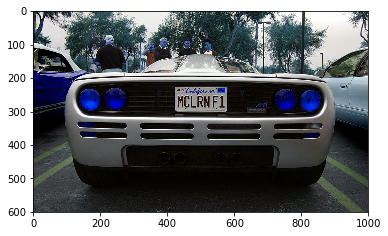

The function 'drawRedRectangleAroundPlate' finished calling.

license plate read from image = MCLRNF1

----------------------------------------
The function 'writeLicensePlateCharsOnImage' finished calling.


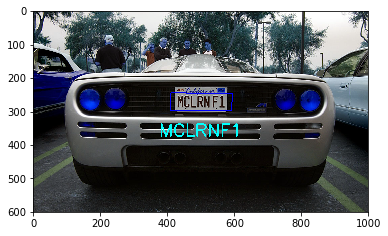

In [46]:
main()